# STIS Coronagraphic Observation Feasibility

Developed by E. Rickman (erickman@stsci.edu)

## Learning Goals

By the end of this example notebook, you will be able to:

- Plot the contrast sensitivity of a STIS coronagraphic observational set up
- Assess the detectability of point sources and/or disk around a given target using STIS coronagraphy

## Introduction

Some of the most important steps in planning and preparing coronagraphic high-contrast observations with STIS involve assessing the feasiblity of a detection of the high-contrast imaging science target (either a point source or a disk) within the capabilities of the predicted contrast sensitivity.

The functions and examples in this notebook are intended to act as a guide to assessing feasibility of high-contrast imaging observations of point sources (i.e. exoplanets, brown dwarf companions) and/or disks around stars for a given expected contrast at the 1, 3 and 5 $\sigma$ level with STIS coronagraphy.

## Guide to usage

The purpose of this notebook is to provide a function to assess the direct imaging detectability of point sources and/or disks around stars using STIS coronagraphy. The predicted noise that is estimated for the contrast sensitivity calculation is based on [Debes et al. 2019](https://www.spiedigitallibrary.org/journals/Journal-of-Astronomical-Telescopes-Instruments-and-Systems/volume-5/issue-03/035003/Pushing-the-limits-of-the-coronagraphic-occulters-on-Hubble-Space/10.1117/1.JATIS.5.3.035003.full#_=_), which contains the full explanation of the treatmeant of each of the noise parameters used in this notebook.

The function `plot_contrast` is used to produce a plot showing the predicted contrast sensitivty and takes the following keywords:
    
    inputs
    ------------------
    tsubexp             : (float) sub-exposure time in seconds
    texp                : (float) total exposure time in seconds (i.e. number of readouts multipled by tsubexp)
    peakpixel_countrate : (float) brightest pixel in a single exposure (count rate in e-/s from the ETC)
    
    optional arguments
    ------------------
    target_name         : (str, default=None) the name of the target
    feature             : (str, default=None) to display a point source or disk ('companion' or 'disk')
    readnoise           : (float, default=8.9) the read noise for the CCD. Default is for the gain setting of 4.
    sdark               : (float, default=0.288) the CCD dark current
    szodi               : (float, default=2.45) noise from zodiacal dust disk in the Solar System
    searth              : (float, default=1.34) noise from scattered light from Earthshine
    comp_sep            : (float, default=None) angular separation between host star and point source ["]
    comp_contrast       : (float, default=None) contrast ratio between host star and point source companion
    disk_profile        : (str, default=None) profile type of the disk to plot, either 'flat' or 'sb_profile'
    disk_contrast       : (float, default=None) contrast ratio between the host star and a disk for flat profile
    disk_filename       : (str, default=None) file name to read in surface brightness profile for a disk
    save_fig            : (str, default=None) set to True to output and save the figure
    plot_psfintensity   : (str, default=True) option to plot the azimuthally averaged STIS PSF intensity
    extract_box_size    : (float, default=3) length of the box of the extraction region, default is a 3x3 box
    
The values for `tsubexp`, `texp`, and `peakpixel_countrate` can be taken directly from the [STIS Exposure Time Calculator](https://etc.stsci.edu/etc/input/stis/imaging/), where a user can input their observational set up to obtain the best estimate for the contrast sensitivity calculation. The image below highlights in green the length of the extraction box (default = 3 pixels, corresponding to a box of 3x3 pixels) and where the `peakpixel_countrate` is taken from for a given observational set up, which is a required input parameter.

The example shown below, for ETC request [1939997](https://etc.stsci.edu/etc/results/STIS.im.1939997/), corresponds to the coronagraphic observing set-up adopted for PID 16991, for the BAR5 occulter, for a V=10.5 mag star. The exposure time for a single frame is `tsubexp` = 440 secs, for a total four frames, giving `texp` = 1760 secs. And the `peakpixel_countrate` in this case is 452,804.530 as highlighted, with the default box extraction size of 3x3 pixels.

![alt text](ETC_example.jpg "Title")

### Loading Data:
In order to read in a custom surface brightness profile for a disk, a .txt file must be provided. In column 1 the user provides the projected separation in arcseconds (") and column 2 is the contrast ratio between the host star and the disk.
    
### Some additional notes:
- The contrast sensivity calculation is intended as a prediction on the contrast sensitivity limit and does not fully take into the account post-processing techniques that may be used. In [Debes et al. 2019](https://www.spiedigitallibrary.org/journals/Journal-of-Astronomical-Telescopes-Instruments-and-Systems/volume-5/issue-03/035003/Pushing-the-limits-of-the-coronagraphic-occulters-on-Hubble-Space/10.1117/1.JATIS.5.3.035003.full#_=_) the predicted limit for a given observational set up is compared against several post-processing methods.
- There is an option to plot the azimuthally averaged STIS PSF intensity as provided on the [STIS Instrument Website](https://www.stsci.edu/~STIS/coronagraphic_bars/GO12923raw.dat).
- The calculation provided here corresponds to the BAR5, WEDGEA0.6, and WEDGEA1.0 aperture locations.

## Imports

**We will import the following packages:**
- `numpy` to handle array functions
- `matplotlib.pyplot` for plotting data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def plot_contrast(texp, tsubexp, peakpixel_countrate, readnoise=8.9, sdark=0.288, szodi=2.45, 
                  searth=1.34, extract_box_size=3, plot_psfintensity=True, target_name=None, feature=None, 
                  comp_sep=None, comp_contrast=None, disk_profile=None, disk_contrast=None, 
                  disk_filename=None, save_fig=None, **kwargs):
    """
    plot_contrast
    ------------------
    Function to plot the contrast sensivity with a point source companion or disk for STIS coronagraphy.
    Displays plot showing 1, 3, and 5 sigma sensitivity curves with the option to plot a companion or disk.
    
    inputs
    ------------------
    tsubexp             : (float) sub-exposure time in seconds
    texp                : (float) total exposure time in seconds (i.e. number of readouts multipled by tsubexp)
    peakpixel_countrate : (float) brightest pixel in a single exposure (count rate in e-/s from the ETC)
    
    optional arguments
    ------------------
    target_name         : (str, default=None) the name of the target
    feature             : (str, default=None) to display a point source or disk ('companion' or 'disk')
    readnoise           : (float, default=8.9) the read noise for the CCD. Default is for the gain setting of 4.
    sdark               : (float, default=0.288) the CCD dark current
    szodi               : (float, default=2.45) noise from zodiacal dust disk in the Solar System
    searth              : (float, default=1.34) noise from scattered light from Earthshine
    comp_sep            : (float, default=None) angular separation between host star and point source ["]
    comp_contrast       : (float, default=None) contrast ratio between host star and point source companion
    disk_profile        : (str, default=None) profile type of the disk to plot, either 'flat' or 'sb_profile'
    disk_contrast       : (float, default=None) contrast ratio between the host star and a disk for flat profile
    disk_filename       : (str, default=None) file name to read in surface brightness profile for a disk
    save_fig            : (str, default=None) set to True to output and save the figure
    plot_psfintensity   : (str, default=True) option to plot the azimuthally averaged STIS PSF intensity
    extract_box_size    : (float, default=3) length of the box of the extraction region, default is a 3x3 box
    
    returns
    ------------------
    Displays figure in line, with option to save figure as an output
    
    """
      
    data = np.loadtxt('GO12923raw.dat', usecols=(0, 1, 2))
    # This file corresponds to the azimuthally averaged STIS PSF wings, with column 1 being the radius in arcsecs and
    # column 2 is the contrast. This is the PSF intensity that is an optional parameter to plot on the contrast curve.
    rawr = data[:, 0]
    rawcont = data[:, 1]
    #rawcont_error = data[:, 2]
    
    spsf = rawcont * peakpixel_countrate # PSF intensity

    n2det = extract_box_size * tsubexp * (sdark + (readnoise)**2/texp) # detector noise^2

    n2bkg = extract_box_size * tsubexp * (szodi + searth) # background noise^2

    n2poiss = extract_box_size * tsubexp * spsf # poission noise^2

    spec_int = 0.00128*(rawr/0.05071)**(-2.86) 
    # empirical fit to the average speckle intensity as a function of radius (Debes et al. 2019)

    n2spec = (spec_int*tsubexp)**2 * peakpixel_countrate**2 * extract_box_size**2 * tsubexp/texp # speckle noise

    totnoise_5sigma = 5*np.sqrt(2*n2det + 2*n2bkg + 2*n2poiss + 2*n2spec) # 5 sigma total noise
    totnoise_3sigma = 3*np.sqrt(2*n2det + 2*n2bkg + 2*n2poiss + 2*n2spec) # 3 sigma total noise
    totnoise_1sigma = 1*np.sqrt(2*n2det + 2*n2bkg + 2*n2poiss + 2*n2spec) # 1 sigma total noise
    # the factor of 2 in each of the noise calculations comes from adding the noise component from 
    # both a reference PSF and a science PSF

    cperpix_5sigma = totnoise_5sigma / (peakpixel_countrate/0.23*0.5*tsubexp) # calculating the contrast per pixel 
    cperpix_3sigma = totnoise_3sigma / (peakpixel_countrate/0.23*0.5*tsubexp)
    cperpix_1sigma = totnoise_1sigma / (peakpixel_countrate/0.23*0.5*tsubexp)
    
    contrast_plot = plt.figure(figsize=(14, 10))

    plt.plot(rawr, cperpix_5sigma, label='Predicted Limit 5 sigma', color='lightsteelblue')
    plt.plot(rawr, cperpix_3sigma, label='Predicted Limit 3 sigma', color='steelblue')
    plt.plot(rawr, cperpix_1sigma, label='Predicted Limit 1 sigma', color='midnightblue')

    plt.fill_between(rawr, cperpix_5sigma, color='lightsteelblue')
    plt.fill_between(rawr, cperpix_3sigma, color='steelblue')
    plt.fill_between(rawr, cperpix_1sigma, color='midnightblue')

    if plot_psfintensity:   # option to plot the PSF intensity on the contrast plot
        plt.plot(rawr, rawcont, ls='--', label='PSF Intensity', color='black', linewidth=2)
    else:
        None        
          
    if feature == 'companion':
        if comp_sep is None or comp_contrast is None:
            raise NameError("Companion separation ('comp_sep') or companion contrast ('comp_contrast') or  not specified.")     
        comp_separation = comp_sep
        comp_contrast = comp_contrast
        target_name = target_name
        plt.plot(comp_separation, comp_contrast, '*', markersize=40, color='orange', label=target_name)
        
    elif feature == 'disk':
        #if 'disk_profile' == None:
        #    raise NameError("Disk surface brightness profile not specified. Must be either 'flat' or 'sb_profile'.")
        
        diskprofile = disk_profile
        
        if diskprofile == 'flat':
            if disk_contrast is None:
                raise NameError("Disk contrast not specified.")
            diskcontrast = disk_contrast
            plt.axhline(diskcontrast, ls='--', linewidth=4, color='orange', label=target_name)
            
        elif diskprofile == 'sb_profile':
            if disk_filename is None:
                raise NameError("Surface brightness profile file name is not specified.")
        
            diskfilename = disk_filename
            disk_sb_profile = np.loadtxt(diskfilename, usecols=(0, 1)) # contrast as a function of radius, rawr here is in arcsecs
            disk_r = disk_sb_profile[:, 0]
            disk_cont = disk_sb_profile[:, 1]
            plt.plot(disk_r, disk_cont, ls='--', linewidth=4, color='orange', label=target_name)
            
        elif diskprofile is None:
            None
            
        else:
            raise NameError("Disk profile not specified. Must be either 'flat' or 'sb_profile'.")
           
    elif feature is None:
        None
        
    plt.legend(fontsize=18, loc='best', markerscale=0.5)
    plt.xlabel('Separation (")', fontsize=20)
    plt.ylabel('Contrast Sensitivity', fontsize=20)
    plt.xlim(0.2, 1.2)
    plt.yscale('log')
    plt.tick_params(axis='both', which='both', labelsize=20, size=6)
    
    if save_fig:
        contrast_plot.savefig('STIS_contrast_plot_'+target_name+'.pdf')

## Example #1: A point source companion

In the example below, is a test case demonstration for a theoretical point source companion in close angular separation to a bright star where the property values of a companion are defined in-line in the function call directly.

- The point source example companion plotted here is shown at 0.6" projected angular separation from it central star at a contrast ratio of 2e-5.
- The dark blue corresponds to the point source companion being under the 1 $\sigma$ direct detection limit. 
- The medium blue corresponds to the parameter space of detectability within the 1-3 $\sigma$ regime.
- The light blue corresponds to the parameter space of detectability within the 3-5 $\sigma$ regime.
- Anything above the light blue 5 $\sigma$ contrast limit in the white region would be predicted to be detectable with the given observational set up.
- The black dotted line shows the azimuthally averaged STIS PSF intensity for comparison, which is the expected contrast curve without coronagraphic post-processing techniques applied, and is an optional parameter to plot.

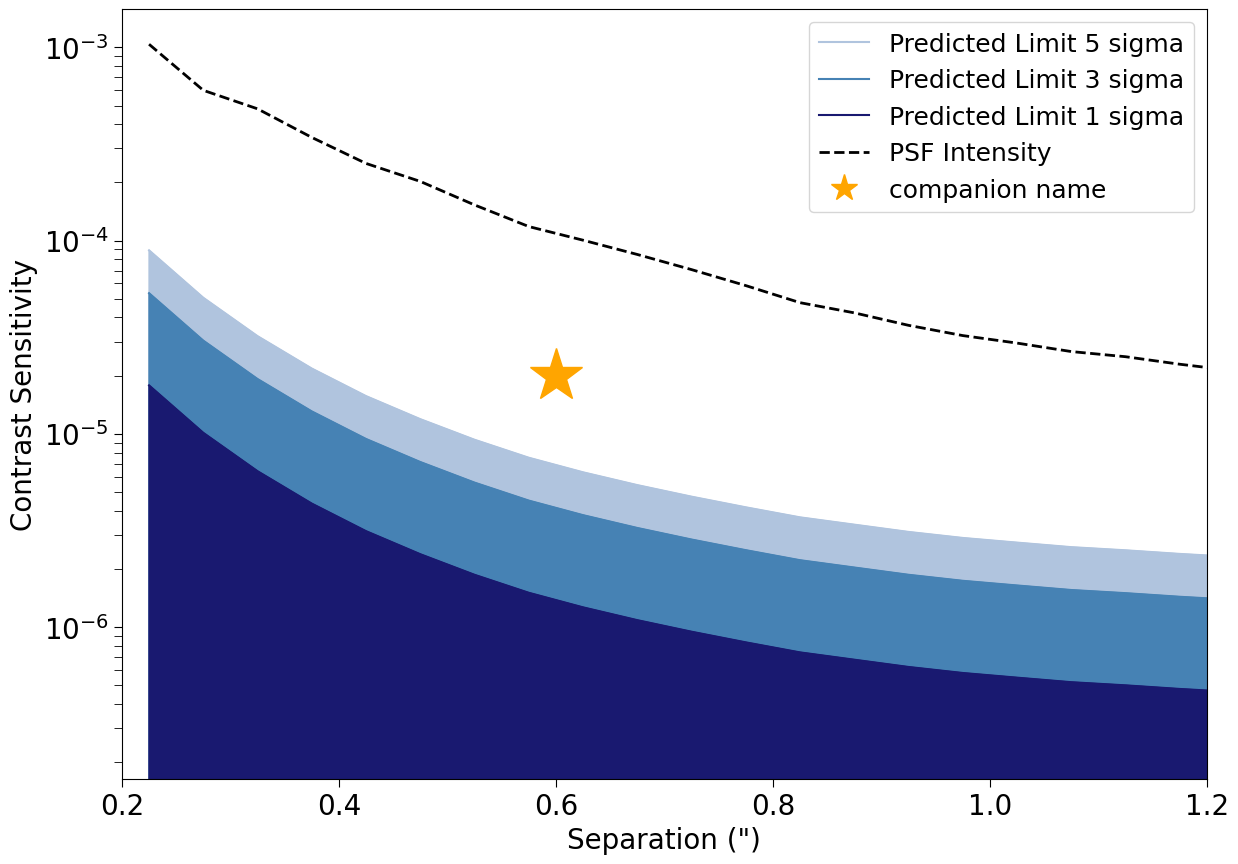

In [3]:
plot_contrast(tsubexp=440.0, texp=1760.0, peakpixel_countrate=452804.530, comp_sep=0.6, comp_contrast=2e-5, feature='companion', target_name='companion name')

## Example #2: A flat disk 

In the example below, the property values of a disk are defined in-line in the function call directly. The resulting figure shows the predicted contrast sensitivity at the 1, 3, and 5 $\sigma$ level as a function of the radius away from the central star in arcseconds ["], with the contrast value of the disk plotted as a horizontal line to represent a predicted peak contrast value for a disk.

- The flat disk profile shown as the dotted orange line is plotted with at a contrast ratio of 1e-5.
- The dark blue corresponds to the disk brightness being under the 1$\sigma$ direct detection limit, and therefore in this case you would not be confident in being able to directly detect the disk at close to the inner working angle with the given observational set up. 
- The medium blue corresponds to the parameter space of detectability within the 1-3 $\sigma$ regime.
- The light blue corresponds to the parameter space of detectability within the 3-5 $\sigma$ regime.
- Anything above the light blue 5 $\sigma$ contrast limit in the white region would be predicted to be detectable with the given observational set up.
- The black dotted line shows the azimuthally averaged STIS PSF intensity for comparison, and is an optional parameter to plot.

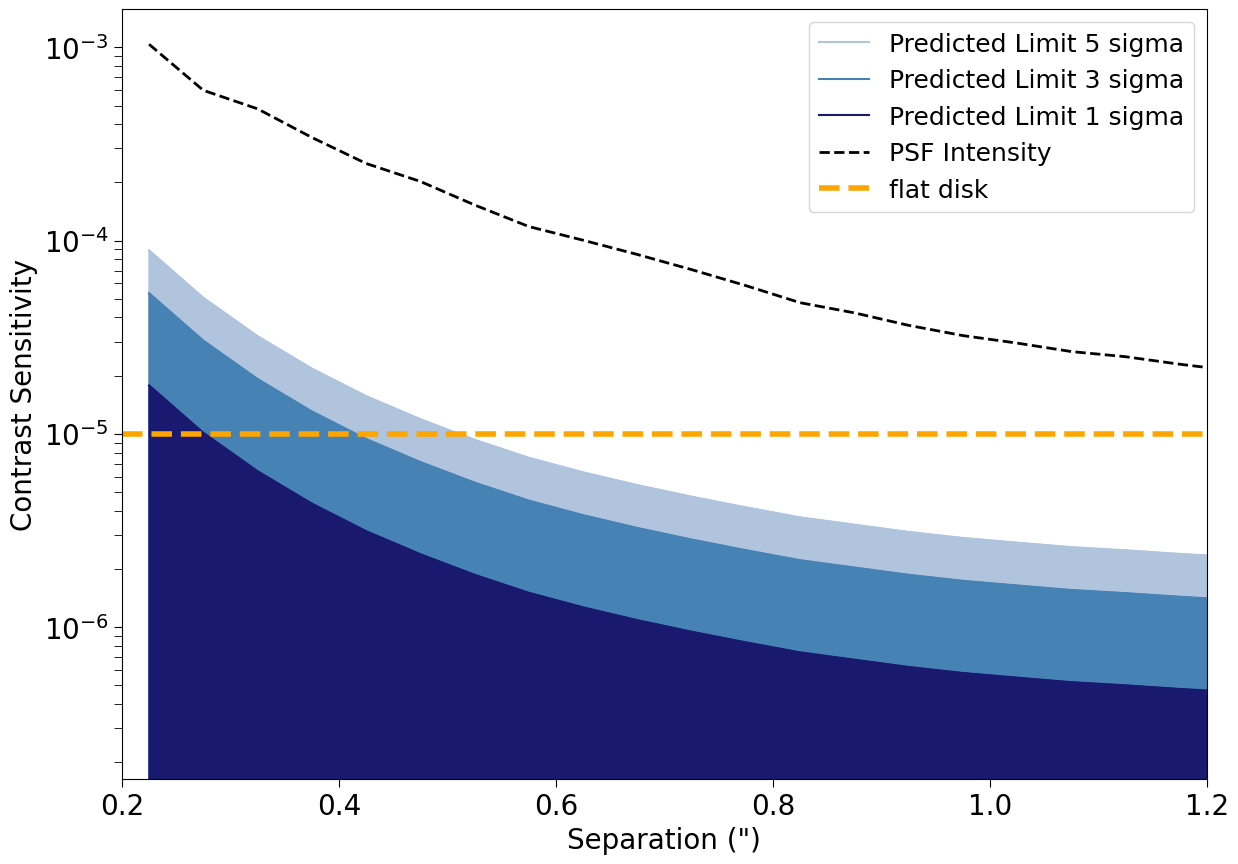

In [4]:
plot_contrast(tsubexp=440.0, texp=1760.0, peakpixel_countrate=452804.530, feature='disk', disk_profile='flat', disk_contrast=1e-5, target_name='flat disk')

## Example #3: A disk with a surface brightness profile

In the example below, the property values of a disk are defined with a .txt file with a column of radius away from the host star in arcseconds and a second column with the contrast ratio. The resulting figure shows the predicted contrast sensitivity at the 1, 3, and 5 $\sigma$ level as a function of the radius away from the central star in arcseconds ["], with the surface brightness profile of the disk from the .txt file plotted.

- The surface brightness disk profile shown as the dotted orange line is read in from a .txt file.
- Anything in the dark blue corresponds to the disk brightness being under the 1$\sigma$ detection limit, and therefore you would not be confident in being able to directly detect the disk at close to the inner working angle with the given observational set up. 
- The medium blue corresponds to the parameter space of detectability within the 1-3 $\sigma$ regime.
- The light blue corresponds to the parameter space of detectability within the 3-5 $\sigma$ regime.
- Anything above the light blue 5 $\sigma$ contrast limit in the white region would be predicted to be detectable with the given observational set up.
- The black dotted line shows the azimuthally averaged STIS PSF intensity for comparison, and is an optional parameter to plot.

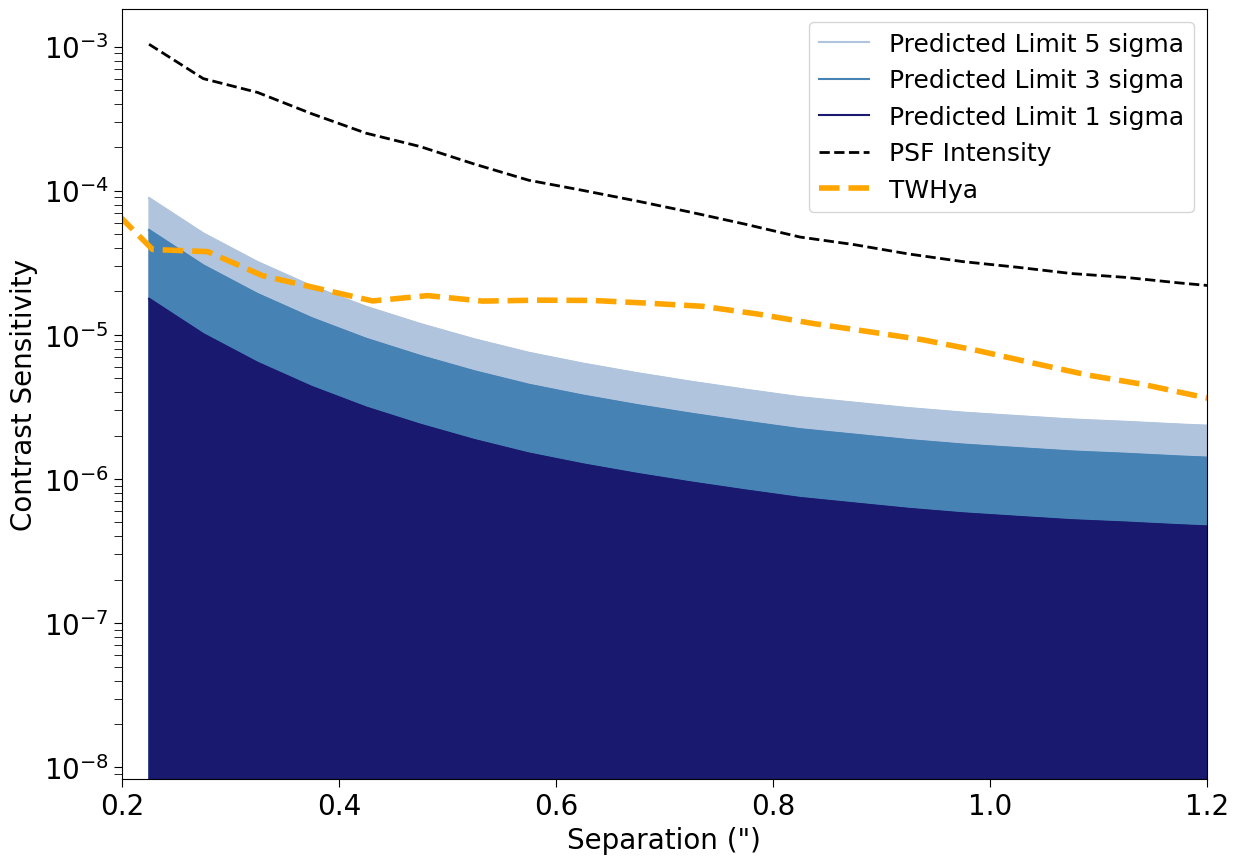

In [5]:
plot_contrast(tsubexp=440.0, texp=1760.0, peakpixel_countrate=452804.530, feature='disk', disk_profile='sb_profile', disk_filename='TWHya.txt', target_name='TWHya')

## Acknowledgements and References

This notebook has been developed with support from John Debes in reference to [Debes et al. 2019](https://www.spiedigitallibrary.org/journals/Journal-of-Astronomical-Telescopes-Instruments-and-Systems/volume-5/issue-03/035003/Pushing-the-limits-of-the-coronagraphic-occulters-on-Hubble-Space/10.1117/1.JATIS.5.3.035003.full#_=_).

Author: Emily Rickman, ESA Science Operations Scientist. \
Updated On: 2024-10-24

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>